# N-Dimensional Newton Bullshit
This code is a non-linear solver that implements the Newton method for N dimensions. Translated into Julia exactly from the MATLAB solutions for PSet 4: NewtonNd.m.
    
### Importing those sexy libraries    

In [66]:
using LinearAlgebra
using Printf
using Polynomials
using Plots
using SparseArrays
using ToeplitzMatrices

### Evaluate function function haha

In [67]:
function evaluate_f(psi,p,V)

    f = p.A*psi - (exp.(psi) - exp.(-psi));  # calculate f at each point
    f[1] = -V/(p.dz)^2 + f[1];               # apply left BC
    f[length(psi)] = f[length(psi)]  + V/(p.dz)^2;   
    
    return f;
end

evaluate_f (generic function with 1 method)

### Evaluate the Poisson fucktion using Jacobian anal methods

In [68]:
function evaluate_Jf(psi,p,V)
    N = size(p.A,2);
    J = p.A - sparse(diagm((exp.(psi) + exp.(-psi))));
    
    return J;
end

evaluate_Jf (generic function with 1 method)

# Ignore this shit for now
### Evaluate the Poisson fucktion using Jacobian finite difference methods
 Evaluates the Jacobian of the vector field `f( )` at state `x0`
 
- `p`: a structure containing all model parameters
- `u`: the value of the imput at the current time
- uses a finite difference approach computing one column k at the time as difference of function evaluations perturbed by scalar `p.dxFD`

Jf(:,k) = (f(x0+p.dxFD) - f(x0)) / p.dxFD

If `p.dxFD` is NOT specified, uses NITSOL value `p.dxFD = 2*sqrt(eps)*max(1,norm(x))`

In [69]:
# function [Jf,dxFD] = eval_Jf_fin_diff(eval_f,x0,p,u)


# N  = length(x0);
# f_x0 = feval(eval_f,x0,p,u);

# if isfield(p,'dxFD')
#    dxFD = p.dxFD;                     %if user specified it: use that
# else
#    %dxFD=sqrt(eps);                   %works ok in general if ||x0|| not huge
#    %dxFD=2*sqrt(eps)*(1+norm(x0,inf));    %correction for ||x0|| very large (works best)
#    %dxFD=2*sqrt(eps)*max(1,norm(x0,inf)); %similar correctly for large ||x0|| 
#    dxFD=2*sqrt(eps)*sqrt(1+norm(x0,inf));     % used in NITSOL solver
#    %dxFD=2*sqrt(eps)*sqrt(max(1,norm(x0,inf)));% similar to NITSOL
#    disp(['dxFD not specified: using 2*sqrt(eps)*sqrt(1+||x||) = ' num2str(dxFD)])
# end

# for k = 1:N,                        % for each column of the Jacobian
#    xk      = x0;
#    xk(k)   = x0(k) + dxFD; 
#    f_xk    = feval(eval_f,xk,p,u);
#    Jf(:,k) = (f_xk - f_x0)/dxFD;
# end



# function eval_Jf_fin_diff(x0,p,u)
#     N  = length(x0);
#     f_x0 = evaluate_f(x0,p,u);

#     if isfield(p,'dxFD')
#        dxFD = p.dxFD;                     %if user specified it: use that
#     else
#        %dxFD=sqrt(eps);                   %works ok in general if ||x0|| not huge
#        %dxFD=2*sqrt(eps)*(1+norm(x0,inf));    %correction for ||x0|| very large (works best)
#        %dxFD=2*sqrt(eps)*max(1,norm(x0,inf)); %similar correctly for large ||x0|| 
#        dxFD=2*sqrt(eps)*sqrt(1+norm(x0,inf));     % used in NITSOL solver
#        %dxFD=2*sqrt(eps)*sqrt(max(1,norm(x0,inf)));% similar to NITSOL
#        disp(['dxFD not specified: using 2*sqrt(eps)*sqrt(1+||x||) = ' num2str(dxFD)])
#     end

#     for k = 1:N,                        % for each column of the Jacobian
#        xk      = x0;
#        xk(k)   = x0(k) + dxFD; 
#        f_xk    = feval(eval_f,xk,p,u);
#        Jf(:,k) = (f_xk - f_x0)/dxFD;
#     end
                        
#     return (Jf, dxFD)
# end

### Get Poisson pussy parameters
precomputes anything that will not change to save time on many calls on `evaluate_f` and `evaluate_Jf`
- `N`: the number of nodes/states/unknowns in the bar (i.e. escluding the boundaries)
- `L`: the total length of the bar
- `dz`: length of each segment 
- `A`: finite difference Laplacian matrix, i.e. the linear part of the function
- `dxFD`: if not specified eval_Jf_fin_diff will default to NITSOL valueif not specified eval_Jf_fin_diff will default to NITSOL value

In [70]:
function get_parameters(N,L)
    dz = L/(N+1);                                        #% length of each segment 
    col = zeros(N); col[1] = 2; col[2] = -1;
    A  = -1/dz^2*Toeplitz(col,col);#% finite difference Laplacian matrix

    dxFD = 8e-4;
    p = pee_maker(dz, A, dxFD)
    return p;
end                            

get_parameters (generic function with 1 method)

### Homotopy Continuation Scheme
from Rey's `newton_v1.jl` code in Github

NOTE: test data for this function has not been done yet!

In [79]:
function homo_cunt(f, x0, err_f, err_deltax, err_relx, dq) # dq = 0.01
    x = x0
    k = 1
    H(x, q) = (1-q) * (x - x0) + q * f(x)
    xs = Vector{Float64}(undef, length(0:dq:1))
    for q ∈ 0:dq:1
        x = newton(Base.Fix2(H, q), x, err_f, err_deltax, err_relx)
        xs[k] = x
        k += 1
        println("\nx($q) = $x\n")
    end
    return x, xs
end

homo_cunt (generic function with 1 method)

### Finally! Compute the Newton method for N dimensions
[add description here and meaning of parameters here]
- `x0`: initial guess for solution $x$
- `p`: parameters for inputs
- `u`: inputs for system
- `err_f`: convergence parameter for error in the final function $f$
- `err_deltax`: convergence parameter for $||\Delta{x}||$
- `rel_deltax`: convergence parameter for $||r\Delta{x}||$ [check to see if this is correct]
- `max_iter`: maximum number of iterations to be run by algorithm if none of the other convergence parameters are achieved
- `visualize`: visualizes the function given; (1) means visualize, (0) means no visualization
- `fin_diff`: indicates whether the Newton methods should be solved with an analytical Jacobian (0) or a finite difference Jacobian (1) method

In [71]:
function NewtonNd(x0,p,u,errf,errDeltax,relDeltax,max_iter,visualize,fin_diff)
    k = 1;   
    X = Float64[];
    X = copy(x0);      
    f = evaluate_f(X[:,k], p, u);
    errf_k      = norm(f,Inf);
    errDeltax_k = Inf;
    relDeltax_k = Inf;
    
    
#     if visualize
#        VisualizeState(1,X,1,'.b');
#     end

    while k<=max_iter && (errf_k>errf || errDeltax_k>errDeltax || relDeltax_k>relDeltax)

#        if fin_diff
#           Jf = eval_Jf_fin_diff(eval_f,X[:,k],p,u);
#        else 
       Jf = evaluate_Jf(X[:,k], p, u);
#        end
       Deltax      = Jf\(-f); 
       X = cat(X, X[:,k] + Deltax, dims=(2,2)) 
       k = k+1;
       f = evaluate_f(X[:,k], p, u);
       errf_k = norm(f,Inf);
       errDeltax_k = norm(Deltax,Inf);
       relDeltax_k = norm(Deltax,Inf)/maximum(abs.(X[:,k]));
#        if visualize
#           VisualizeState([1:1:k],X,k,'.b');
#        end
    end

    x = X[:,k];
    
    iterations = k-1; 
    if errf_k<=errf && errDeltax_k<=errDeltax && relDeltax_k<=relDeltax
       converged = 1;
#        if visualize
          @printf("Newton converged in %d iterations\n", iterations);
#        end
    else
       converged = 0;
       @printf("Newton did NOT converge! Maximum Number of Iterations reached\n");
    end
    
    
    return (x,converged,errf_k,errDeltax_k,relDeltax_k,iterations,X)
end

NewtonNd (generic function with 1 method)

### Testing N-Dimensional Newton methods
`get_parameters` precomputes and stores anything that will not change to save time on many calls to evaluate_f and evaluate_Jf. `pee_maker` is a struct that creates the necessary members for the parameter variable, `p`.
- `L`: total length of the domain
- `N`: numer of discretization elements on the domain
- `V`: u is the input i.e. V
- `psi`: range of values just for plotting  
- `psi0`: initial guess of potentials distributions for Newton 
- `fin_diff`: if (1), uses the finite difference method that I never wrote for Julia because idk if we need it, if (0) uses provided evaluate_Jf function for Jacobian 

In [72]:
struct pee_maker
    dz
    A
    dxFD
end

L    = 1;       
N    = 100;     
V    = 10;     
psi  = [-20:.5:20];
psi0 = zeros(N); 
pee  = get_parameters(N,L); 


# % termination criteria for GCR inside Newton
# % this gives fewest function calls when normalizing epsMF for ||r_j|| and ||x||
# tolrGCR   = 1e-4;  #% convergence criteria on the GCR residual inside Newton
# epsMF     = 1e-6;  #% perturbation for directional finite difference jacobian

#% termination criteria for Newton 
errf = 1e-10;
errDeltax = 1e-8;
relDeltax = Inf; 

max_iter   = 200;   
visualize = 0;    
fin_diff=0; 

# Solving with Newton LU
(psif_LU,converged,errf_k,errDeltax_k,relDeltax_k,iterations,psis_LU) = NewtonNd(psi0,pee,V,errf,errDeltax,relDeltax,max_iter,visualize,fin_diff);

Newton converged in 8 iterations


### Visualize the function

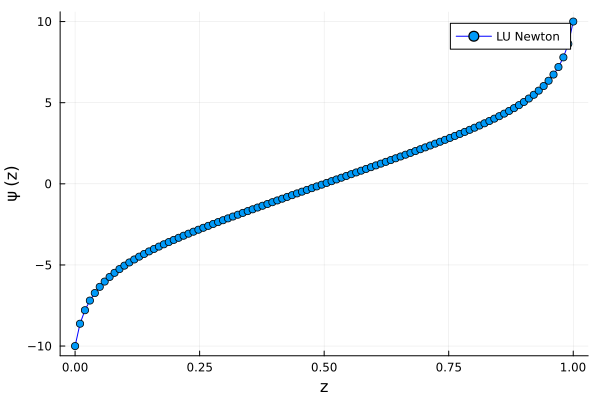

In [73]:
psifplot_LU = [-V; psif_LU; V];
z = range(0,1,N+2);

plot(z, psifplot_LU, markershape=:circle, linecolor="blue", label="LU Newton");
xlabel!("z")
ylabel!("\\psi (z)")
savefig("function.png")

### Plot $k$ vs. $||\psi^{k} - \psi^{*}||$

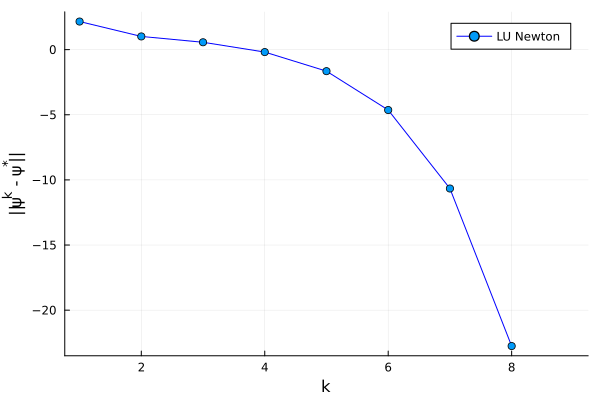

In [74]:
N_error_LU = size(psis_LU,2);
error_norm_LU = Float64[];
f_psi_norm_LU = Float64[];
# delta_psi_norm_LU = FLoat64[];
for h in 1:N_error_LU
#    f_psi_norm_LU[h]        = norm(evaluate_f(psis_LU[:,h],pee,V),Inf);
    if h == 1
        f_psi_norm_LU = norm(evaluate_f(psis_LU[:,h],pee,V),Inf);
        error_norm_LU = norm(psis_LU[:,h] - psif_LU, Inf);
        
    else
        f_psi_norm_LU = cat(f_psi_norm_LU, norm(evaluate_f(psis_LU[:,h],pee,V),Inf), dims=(2,2));
        error_norm_LU = cat(error_norm_LU, norm(psis_LU[:,h] - psif_LU, Inf), dims=(2,2));
    end

#    if h > 1
#       delta_psi_norm_LU[h] = norm(psis_LU[:,h] - psis_LU[:,h-1], Inf);
#    end
end

x_axis = range(1,N_error_LU)
plot(x_axis, log.(error_norm_LU'), markershape = :circle, linecolor="blue", label="LU Newton")
xlabel!("k")
ylabel!("||\\psi^{k} - \\psi^{\\*}||")
savefig("k_vs_psi-k-psi-star.png")

### Plot $||\psi^{k} - \psi^{*}||$ vs. $||\psi^{k+1} - \psi^{*}||$
This homophobic doodoo is not working the way I want it to because even though it's linear just like the MATLAB version, it's not the right loglog scale at all (T-T)

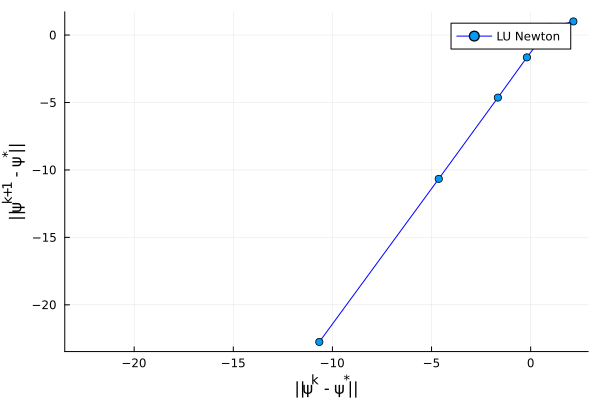

In [75]:
error_norm_k_LU = error_norm_LU[1:N_error_LU-1];
error_norm_kp1_LU = error_norm_LU[2:N_error_LU];

plot(log.(error_norm_k_LU), log.(error_norm_kp1_LU), markershape = :circle, linecolor="blue", label="LU Newton")
# legend('Newton-GCRmf','Newton-GCR','Newton-LU',2)
xlabel!("||\\psi^{k} - \\psi^{\\*}||")
ylabel!("||\\psi^{k+1} - \\psi^{\\*}||")
savefig("psi-k-psi-star_vs_psi-kp1-psi-star.png")

### I dunno nor do I care what these are but I probably should

In [76]:
# figure
# semilogy(delta_psi_norm_LU,   'b')
# legend('Newton-GCRmf','Newton-GCR','Newton-LU',1)
# xlabel('k')
# ylabel('||\Delta\psi^k||_\infty')


In [77]:
# figure
# semilogy(f_psi_norm_LU,   'b')
# legend('Newton-GCRmf','Newton-GCR','Newton-LU',1)
# xlabel('k')
# ylabel('||f(\psi^k)||_\infty')

### Get the convergence order of the function

In [78]:
# % remove first and last
error_norm_k_fit_LU = error_norm_k_LU[2:length(error_norm_k_LU)-1];  
error_norm_kp1_fit_LU = error_norm_kp1_LU[2:length(error_norm_kp1_LU)-1];  

params_LU = fit(log.(error_norm_k_fit_LU), log.(error_norm_kp1_fit_LU), 1);
ConvergenceOrder_Newton_LU = params_LU[1];

@printf("The convergence order of this sexy bitch is %f, or order %d \n", ConvergenceOrder_Newton_LU, round(ConvergenceOrder_Newton_LU))

The convergence order of this sexy bitch is 2.006563, or order 2 
